# Matching when including the contralateral connections

## Preliminaries

In [1]:
from pkg.utils import set_warnings

set_warnings()


import datetime
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment
import seaborn as sns
from numba import jit

from giskard.plot import matched_stripplot
from pkg.data import load_maggot_graph
from pkg.io import savefig
from pkg.plot import set_theme
from pkg.utils import get_paired_inds, get_paired_subgraphs


t0 = time.time()


def stashfig(name, **kwargs):
    foldername = "matching_w_contra"
    savefig(name, foldername=foldername, **kwargs)


set_theme()

colors = sns.color_palette("Set1")
palette = dict(zip(["Left", "Right"], colors))

### Load the data

In [2]:
mg = load_maggot_graph()
mg = mg[mg.nodes["paper_clustered_neurons"]]

## Include the contralateral connections in graph matching

### Set up the experiment

In [3]:
np.random.seed(8888)
maxiter = 30
verbose = False
ot = False
maximize = True
reg = np.nan  # TODO could try GOAT
thr = np.nan
tol = 1e-4
n_init = 10

lp_inds, rp_inds = get_paired_inds(mg.nodes)
ll_adj, rr_adj, lr_adj, rl_adj = get_paired_subgraphs(mg.sum.adj, lp_inds, rp_inds)
n = len(lp_inds)


@jit(nopython=True)
def compute_gradient(A, B, AB, BA, P):
    return A @ P @ B.T + A.T @ P @ B + AB @ P.T @ BA.T + BA.T @ P.T @ AB


@jit(nopython=True)
def compute_step_size(A, B, AB, BA, P, Q):
    R = P - Q
    # TODO make these "smart" traces like in the scipy code, couldn't hurt
    # though I don't know how much Numba cares
    a_cross = np.trace(AB.T @ R @ BA @ R)
    b_cross = np.trace(AB.T @ R @ BA @ Q) + np.trace(AB.T @ Q @ BA @ R)
    a_intra = np.trace(A @ R @ B.T @ R.T)
    b_intra = np.trace(A @ Q @ B.T @ R.T + A @ R @ B.T @ Q.T)

    a = a_cross + a_intra
    b = b_cross + b_intra

    if a * obj_func_scalar > 0 and 0 <= -b / (2 * a) <= 1:
        alpha = -b / (2 * a)
    return alpha
    # else:
    #     alpha = np.argmin([0, (b + a) * obj_func_scalar])
    # return alpha


@jit(nopython=True)
def compute_objective_function(A, B, AB, BA, P):
    return np.trace(A @ P @ B.T @ P.T) + np.trace(AB.T @ P @ BA @ P)

### Run the graph matching experiment

In [4]:
rows = []
for init in range(n_init):
    if verbose > 0:
        print(f"Initialization: {init}")
    shuffle_inds = np.random.permutation(n)
    correct_perm = np.argsort(shuffle_inds)
    A_base = ll_adj.copy()
    B_base = rr_adj.copy()
    AB_base = lr_adj.copy()
    BA_base = rl_adj.copy()

    for between_term in [True, False]:
        init_t0 = time.time()
        if verbose > 0:
            print(f"Between term: {between_term}")
        A = A_base
        B = B_base[shuffle_inds][:, shuffle_inds]
        AB = AB_for_obj = AB_base[:, shuffle_inds]
        BA = BA_for_obj = BA_base[shuffle_inds]

        if not between_term:
            AB = np.zeros((n, n))
            BA = np.zeros((n, n))

        P = np.full((n, n), 1 / n)

        obj_func_scalar = 1
        if maximize:
            obj_func_scalar = -1

        for n_iter in range(1, maxiter + 1):

            # [1] Algorithm 1 Line 3 - compute the gradient of f(P)
            currtime = time.time()
            grad_fp = compute_gradient(A, B, AB, BA, P)
            if verbose > 1:
                print(f"{time.time() - currtime:.3f} seconds elapsed for grad_fp.")

            # [1] Algorithm 1 Line 4 - get direction Q by solving Eq. 8
            currtime = time.time()
            if ot:
                # TODO not implemented here yet
                Q = alap(grad_fp, n, maximize, reg, thr)
            else:
                _, cols = linear_sum_assignment(grad_fp, maximize=maximize)
                Q = np.eye(n)[cols]
            if verbose > 1:
                print(
                    f"{time.time() - currtime:.3f} seconds elapsed for LSAP/Sinkhorn step."
                )

            # [1] Algorithm 1 Line 5 - compute the step size
            currtime = time.time()

            alpha = compute_step_size(A, B, AB, BA, P, Q)

            if verbose > 1:
                print(
                    f"{time.time() - currtime:.3f} seconds elapsed for quadradic terms."
                )

            # [1] Algorithm 1 Line 6 - Update P
            P_i1 = alpha * P + (1 - alpha) * Q
            if np.linalg.norm(P - P_i1) / np.sqrt(n) < tol:
                P = P_i1
                break
            P = P_i1
            _, iteration_perm = linear_sum_assignment(-P)
            match_ratio = (correct_perm == iteration_perm).mean()

            objfunc = compute_objective_function(A, B, AB_for_obj, BA_for_obj, P)

            if verbose > 0:
                print(
                    f"Iteration: {n_iter},  Objective function: {objfunc:.2f},  Match ratio: {match_ratio:.2f}"
                )

            row = {
                "init": init,
                "iter": n_iter,
                "objfunc": objfunc,
                "match_ratio": match_ratio,
                "between_term": between_term,
                "time": time.time() - init_t0,
            }
            rows.append(row)

        if verbose > 0:
            print("\n")

    _, perm = linear_sum_assignment(-P)
    if verbose > 0:
        print("\n")

results = pd.DataFrame(rows)
results

,init,iter,objfunc,match_ratio,between_term,time
0,0,1,2.439440e+05,0.119651,True,3.882579
1,0,2,5.403489e+05,0.303057,True,4.597101
2,0,3,7.584659e+05,0.536245,True,5.387571
3,0,4,8.597453e+05,0.705677,True,6.125518
4,0,5,9.131593e+05,0.791266,True,6.823432
...,...,...,...,...,...,...
578,9,26,1.028481e+06,0.797380,False,21.769940
579,9,27,1.028621e+06,0.796507,False,22.507314
580,9,28,1.028734e+06,0.796507,False,23.282349
581,9,29,1.028840e+06,0.797380,False,24.036791


### Plot the results

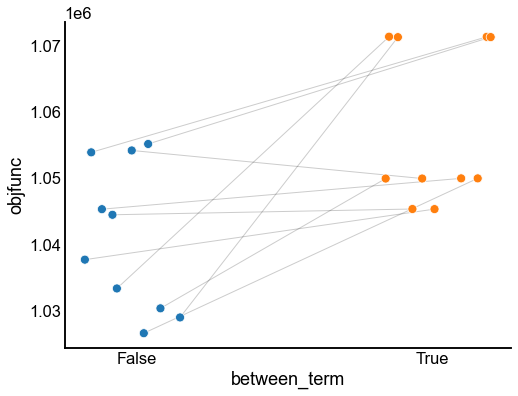

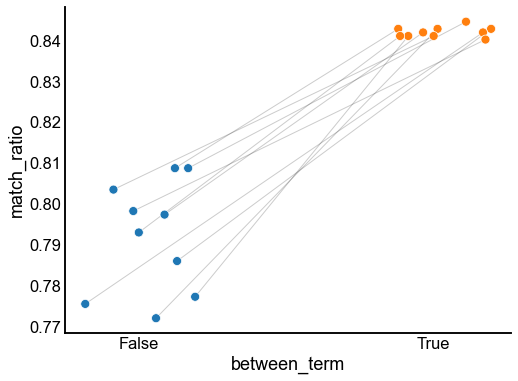

In [5]:
last_results_idx = results.groupby(["between_term", "init"])["iter"].idxmax()
last_results = results.loc[last_results_idx].copy()

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
matched_stripplot(
    last_results,
    jitter=0.2,
    x="between_term",
    y="objfunc",
    match="init",
    hue="between_term",
)
stashfig("between-objfunc")


fig, ax = plt.subplots(1, 1, figsize=(8, 6))
matched_stripplot(
    last_results,
    jitter=0.2,
    x="between_term",
    y="match_ratio",
    match="init",
    hue="between_term",
)
stashfig("between-match-ratio")

## End

In [6]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print("----")
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")
print("----")

----
Script took 0:09:32.367455
Completed at 2021-04-02 09:48:19.888251
----
